In [1]:
import numpy as np
import pandas as pd
import pickle
import nest
from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils
from RONs import ChR_dynamics
from RONs import LoadReducedOptogeneticNeurons
from neurostim.stimulator import Stimulator
from neurostim.model_reduction import calc_fluxes_photons_PER_cm2_fs


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Apr  3 2024 10:07:39

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
point_neuron_model_path = 'fig1_point_neuron_simulation/fit_to_L23_PC_cADpyr229_1.nestml'
x_soma, y_soma, z_soma = np.load('fig1_point_neuron_simulation/L23_PC_cADpyr229_1-cluster_50-cond_scl_0.15-soma_location.npy')
temp_protocol = dict(
    duration_ms = 200,
    delay_ms = 1,
    total_rec_time_ms=250,
    interpol_dt_ms = 1
)
diameter_um=50
NA=0.1
stim_intensity_mWPERmm2 = 0.1
fiber_power_mW = stim_intensity_mWPERmm2 * (diameter_um/2/1000)**2 * np.pi
stimulator = Stimulator(diameter_um=diameter_um, NA=NA)
# optogenetic expression conversion factor:
conversion_factor = 17/(50e-6) # 17nS for HEK cell, 50fS for single channel in full conduction mode.
conversion_factor *= 0.6

In [3]:
module_name, neuron_model_name = NESTCodeGeneratorUtils.generate_code_for(point_neuron_model_path)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Apr  3 2024 10:07:39

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[12,aeif_cond_exp_neuron_nestml, WARNING, [75:8;75:20]]: Variable 'a' has the same name as a physical unit!
[23,aeif_cond_exp_neuron_nestml, WARNING, [75:8;75:20]]: Variable 'a' has the same name as a physical unit!
[30,aeif_cond_exp_neuron_nestml, WARNING, [75:8;75:20]]: Variable 'a' has the same name as a physical unit!
CMake Warning (dev) at CMakeLists.txt:93 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The CXX compiler identification is GNU

In [4]:
def nest_sim(stim_times, stim_cond):
    
    nest.ResetKernel()

    nest.Install(module_name)

    neuron = nest.Create(neuron_model_name)

    voltmeter = nest.Create("voltmeter")
    voltmeter.set({"record_from": ["V_m"]})
    nest.Connect(voltmeter, neuron)

    sr = nest.Create("spike_recorder")
    nest.Connect(neuron, sr)

    scg = nest.Create('step_current_generator')

    nest.Connect(scg, neuron)

    scg.set({'amplitude_times':stim_times, 'amplitude_values':stim_cond,'stop':stim_times[-1]})

    nest.Simulate(stim_times[-1])

    return voltmeter.get("events")["times"], voltmeter.get("events")["V_m"], nest.GetStatus(sr, keys='events')[0]['times']
    
def simulate_APC(time_ms, conductance_nS):
    APCs = []
    if (conductance_nS.shape == ()) and np.isnan(conductance_nS) == True:
        # calculation of conductance was rejected. Save dummy file.
        APCs.append(
            dict(
                simtype='RON_adex',
                patt_id = int(snakemake.wildcards.patt_id),
                cond_scale_factor = float(snakemake.wildcards.cond_scale_fct),
                norm_power_mW_of_MultiStimulator = float(snakemake.wildcards.norm_power),
                APC=np.nan
            )
        )
        return pd.DataFrame(APCs)
    else:
        # proceed with simulation
    
        # take time 0 away (nest does not like time 0):
        time_ms = time_ms[1:]
        conductance_nS = conductance_nS[1:]
        # convert times to float as nest expects float not int
        time_ms = time_ms.astype(float)
    
        times, Vm, spike_times = nest_sim(time_ms, conductance_nS)
    
        APCs.append(
            dict(
                APC=len(spike_times)
            )
        )
        return pd.DataFrame(APCs)
        
def get_conductance_nS(x, y, z, temp_protocol=temp_protocol, fiber_power_mW=fiber_power_mW, stimulator=stimulator):
    # set up stimulator
    fluxes = calc_fluxes_photons_PER_cm2_fs(
        comp_xyz=[x,y,z],
        stimulator=stimulator,
        norm_power_mW_of_MultiStimulator=fiber_power_mW
    )
    times = np.arange(0,temp_protocol['total_rec_time_ms'],temp_protocol['interpol_dt_ms'])
    on = np.zeros(shape=times.shape)
    on[int(temp_protocol['delay_ms']/temp_protocol['interpol_dt_ms']):int(
        (temp_protocol['delay_ms']+temp_protocol['duration_ms'])/temp_protocol['interpol_dt_ms'])
       ] = 1
    fluxes = np.array([flux * on for flux in fluxes])

    # init ChR
    ChR_model = ChR_dynamics()
    conductance_nS = ChR_model.calculate(fluxes_photonsPERcm2_fs=fluxes, update_interval=temp_protocol['interpol_dt_ms'])
    return conductance_nS

In [5]:
xys = np.arange(-100, 110, 10) 
#xys = [0]
xx, yy = np.meshgrid(xys, xys)
results = []
for x_,y_ in zip(xx.flatten(), yy.flatten()):
    conductance_nS = get_conductance_nS(
        x=np.array([x_-x_soma]),
        y=np.array([y_-y_soma]),
        z=np.array([z_soma])
    )[0]
    time_ms = np.arange(0,temp_protocol['total_rec_time_ms'],temp_protocol['interpol_dt_ms'])
    APC = simulate_APC(time_ms, conductance_nS*conversion_factor)
    APC['x'] = x_
    APC['y'] = y_
    results.append(APC)

results = pd.concat(results)
results.to_csv('point_neuron_activation_stim_int'+str(stim_intensity_mWPERmm2)+'_Nchannels'+str(conversion_factor)+'.csv')
results.loc[(results.x==0) & (results.y==0)]


Apr 03 15:07:39 Install [Info]: 
    loaded module nestml_05ae8f923f3740c68a085925e8189dc0_module

Apr 03 15:07:39 NodeManager::prepare_nodes [Info]: 
    Preparing 4 nodes for simulation.

Apr 03 15:07:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4
    Simulation time (ms): 249
    Number of OpenMP threads: 1
    Not using MPI

Apr 03 15:07:39 SimulationManager::run [Info]: 
    Simulation finished.

Apr 03 15:07:39 Install [Info]: 
    loaded module nestml_05ae8f923f3740c68a085925e8189dc0_module

Apr 03 15:07:39 NodeManager::prepare_nodes [Info]: 
    Preparing 4 nodes for simulation.

Apr 03 15:07:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4
    Simulation time (ms): 249
    Number of OpenMP threads: 1
    Not using MPI

Apr 03 15:07:39 SimulationManager::run [Info]: 
    Simulation finished.

Apr 03 15:07:39 Install [Info]: 
    loaded module nestml_05ae8f923f3740c68a085925e8189dc0_module

Apr 03 15:07:39 NodeManager::pre

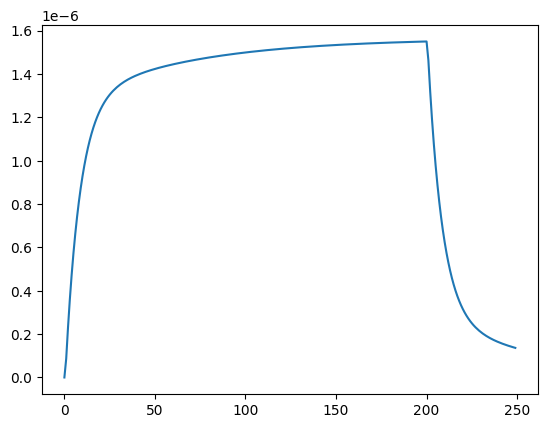

In [6]:
import matplotlib.pyplot as plt
plt.plot(conductance_nS*conversion_factor)